# Hands-on exercise

Model setup is as follows: we have dijet asymmetry data prepared, where the asymmetry $A_J$ is defined as the difference between the two jets divided by the sum. Specifically,

$$A_{\mathrm{J}} = \frac{p_{\mathrm{T, 1}} - p_{\mathrm{T, 2}}}{p_{\mathrm{T, 1}} + p_{\mathrm{T, 2}}}$$

We will construct a model to describe the energy loss observed in the dijet asymmetry.  For this model, we consider back-to-back dijets.  Each jet can lose energy, and the lost energy is parameterized as

$$ \Delta p_{\mathrm{T}} / p_{\mathrm{T}} \sim A \times Gaus(1, 1)$$

In addition to the energy loss contribution, we have extra "apparent" smearing on the $A_J$ coming from the fact that we have other processes going on in the events (three jets etc).  It is parameterized as a Gaussian smearing on $A_J$ with width $B$. So there are two total parameters: $A$ and $B$.

The measurement is done in two bins of centrality.  One in central event, where ($A$, $B$) are all relevant, and another one in very peripheral event, where only the parameter ($B$) is relevant.


## Loading python packages

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input file

### Load stuff from text files

The `Reader` class implements the interface between input data files and the code.  There are functions to read in experimental data, externally-supplied covariance matrix, design points, and calculations for the design points

In [2]:
# Read data files
RawData1 = Reader.ReadData('input/AJExample/Data_Selection1.dat')   # Central bin data
RawData2 = Reader.ReadData('input/AJExample/Data_Selection2.dat')   # Peripheral bin data

# Read covariance -- if you have covariance matrix from the experiments for example
# RawCov1 = Reader.ReadCovariance('input/AJExample/______.dat')
# RawCov2 = Reader.ReadCovariance('input/AJExample/______.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/AJExample/Design.dat')   # Design points!

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/AJExample/Prediction_Selection1.dat')   # Calculation for central bin
RawPrediction2 = Reader.ReadPrediction('input/AJExample/Prediction_Selection2.dat')   # Calculation for peripheral

### Setup analysis

In addition to reading stuff, there is also a `EstimateCovariance` function that estimates the covariance for you.  It is configurable to do different correlation treatment for different systematic uncertainty sources (and then add them all up!).  We can also correlate across different measurements.

In [3]:
# Initialize empty dictionary
AllData = {}

C0 = 'Central'
C1 = 'Peripheral'

# Basic information
AllData["systems"] = ["PbPb5020"]                 # List of collision systems we are doing
AllData["keys"] = RawDesign["Parameter"]          # Get the "A" and "B" from the design file
AllData["labels"] = RawDesign["Parameter"]        # Get the "A" and "B" from the design file
AllData["ranges"] = [(0, 0.3), (0, 0.3)]          # Range of A and B
AllData["observables"] = [('A_J', [C0, C1])]      # We measure A_J with two bins: "Central" and "Peripheral"
# In this example "C0" is central data, and "C1" is peripheral => see above

# Data points
Data = {"PbPb5020": {"A_J": {C0: RawData1["Data"], C1: RawData2["Data"]}}}

# Model predictions
Prediction = {"PbPb5020": {"A_J": {C0: {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   C1: {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}}}}

# Correlation length toggles
# Change to 9999 to make it fully correlated,or -1 for fully uncorrelated
# Also try 0.1 for partially correlated
CorrelationLength = -1
OffDiagonalCorrelationLength = -1

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["PbPb5020"][("A_J", C0)][("A_J", C0)] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": CorrelationLength}, ScaleX = False)
Covariance["PbPb5020"][("A_J", C1)][("A_J", C1)] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": CorrelationLength}, ScaleX = False)
Covariance["PbPb5020"][("A_J", C0)][("A_J", C1)] = Reader.EstimateCovariance(RawData1, RawData2, SysLength = {"default": OffDiagonalCorrelationLength}, ScaleX = False)
Covariance["PbPb5020"][("A_J", C1)][("A_J", C0)] = Reader.EstimateCovariance(RawData2, RawData1, SysLength = {"default": OffDiagonalCorrelationLength}, ScaleX = False)

# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired file
with open('input/default.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Plotting inputs

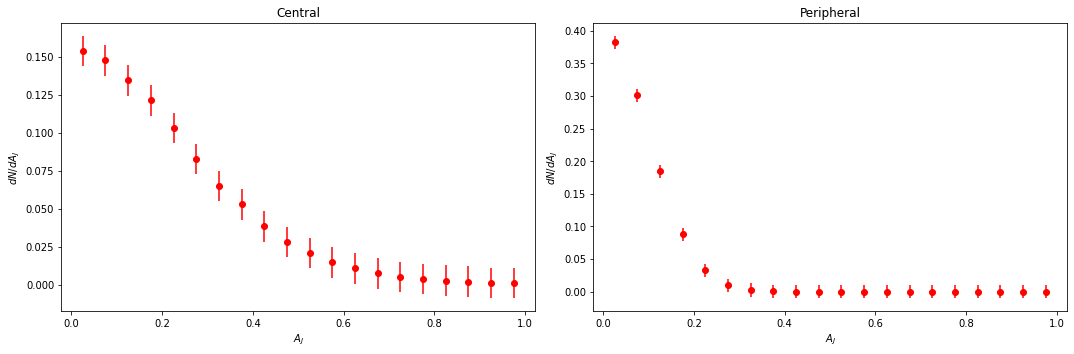

In [4]:
# Let's plot the input data!

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

axes[0].set_title('Central')
axes[1].set_title('Peripheral')
    
plt.tight_layout(True)
figure.savefig('InputData.pdf', dpi = 192)
# figure

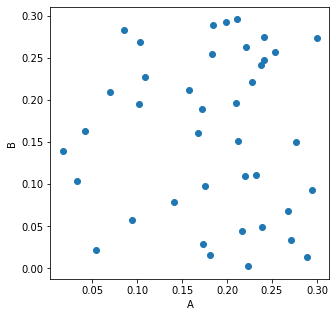

In [5]:
# Plot 2D scatter plot of the design points
figure, axis = plt.subplots(figsize = (5, 5), ncols = 1, nrows = 1)
axis.plot(AllData["design"][:,0], AllData["design"][:,1], 'o')
axis.set_xlabel('A')
axis.set_ylabel('B')
figure.savefig('DesignPoints.pdf', dpi = 192)

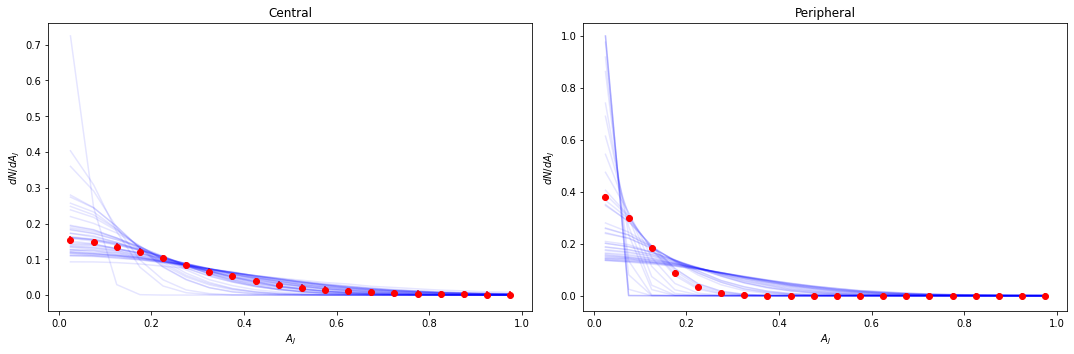

In [6]:
# Plotting the input data overlaid on top of the design point calculations

TempPrediction = AllData["model"]

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
    for i, y in enumerate(TempPrediction[S1][O][S2]['Y']):
        axes[s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

axes[0].set_title('Central')
axes[1].set_title('Peripheral')
    
plt.tight_layout(True)
figure.savefig('Design.pdf', dpi = 192)
# figure

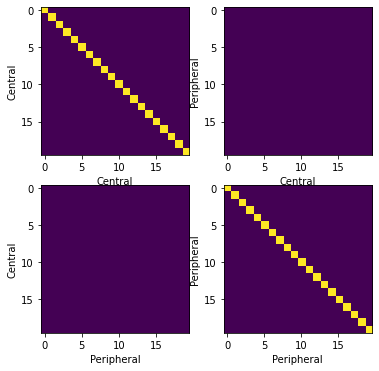

In [7]:
# Visualize the covariance matrix

MaxValue = np.array(
    [Covariance["PbPb5020"][("A_J", C0)][("A_J", C0)].max(),
     Covariance["PbPb5020"][("A_J", C0)][("A_J", C1)].max(),
     Covariance["PbPb5020"][("A_J", C1)][("A_J", C0)].max(),
     Covariance["PbPb5020"][("A_J", C1)][("A_J", C1)].max()]).max()

figure, axes = plt.subplots(figsize = (6, 6), ncols = 2, nrows = 2)
axes[0][0].imshow(Covariance["PbPb5020"][("A_J", C0)][("A_J", C0)], vmin=0, vmax=MaxValue)
axes[0][1].imshow(Covariance["PbPb5020"][("A_J", C0)][("A_J", C1)], vmin=0, vmax=MaxValue)
axes[1][0].imshow(Covariance["PbPb5020"][("A_J", C1)][("A_J", C0)], vmin=0, vmax=MaxValue)
axes[1][1].imshow(Covariance["PbPb5020"][("A_J", C1)][("A_J", C1)], vmin=0, vmax=MaxValue)

axes[0][0].set_xlabel('Central')
axes[0][1].set_xlabel('Central')
axes[1][0].set_xlabel('Peripheral')
axes[1][1].set_xlabel('Peripheral')

axes[0][0].set_ylabel('Central')
axes[0][1].set_ylabel('Peripheral')
axes[1][0].set_ylabel('Central')
axes[1][1].set_ylabel('Peripheral')

figure.savefig('Covariance.pdf', dpi = 192)

### Clean past files so that they don't haunt us later on

In [8]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [9]:
# Train emulator with 8 principle components
! python3 -m src.emulator --retrain --npc 8

[INFO][emulator] training emulator for system PbPb5020 (8 PC, 0 restarts)
[0.3 0.3]
[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl
PbPb5020
8 PCs explain 0.99547 of variance
GP 0: 0.62370 of variance, LML = 53.934, kernel: 9.86**2 * Matern(length_scale=[3, 1.8], nu=1.5) + WhiteKernel(noise_level=0.0001)
GP 1: 0.12731 of variance, LML = 8.9919, kernel: 6.64**2 * Matern(length_scale=[0.889, 0.64], nu=1.5) + WhiteKernel(noise_level=0.000247)
GP 2: 0.11652 of variance, LML = 23.986, kernel: 9.8**2 * Matern(length_scale=[1.5, 1.19], nu=1.5) + WhiteKernel(noise_level=0.000233)
GP 3: 0.05899 of variance, LML = 2.2994, kernel: 4.55**2 * Matern(length_scale=[0.574, 0.446], nu=1.5) + WhiteKernel(noise_level=0.00035)
GP 4: 0.03757 of variance, LML = -18.157, kernel: 5.91**2 * Matern(length_scale=[0.636, 0.29], nu=1.5) + WhiteKernel(noise_level=0.00131)
GP 5: 0.01972 of variance, LML = -22.267, kernel: 3.2**2 * Matern(length_scale=[0.238, 0.237], nu=1.5) + WhiteKernel(noise_level=

In [10]:
# Read in emulator object into this notebook for plotting purposes
from src import lazydict, emulator
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

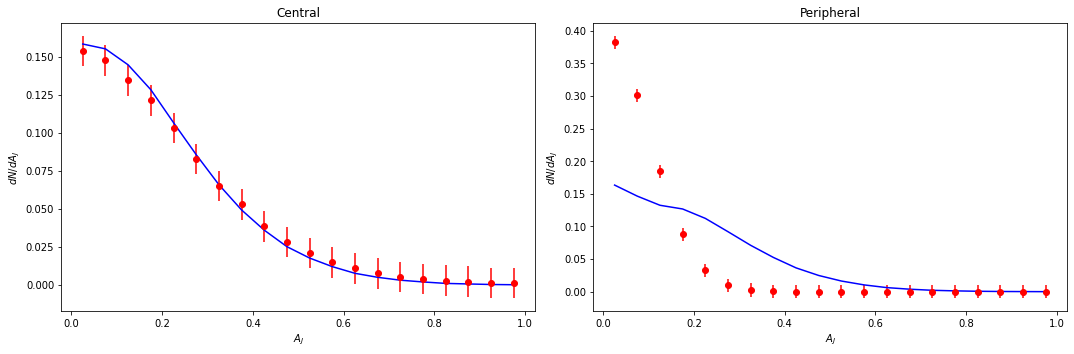

In [11]:
# Test running some prediction to see if things make sense
# Try [0.0, 0.25], [0.1, 0.0], [0.2, 0.1], etc
# Note the maximum range is 0.3.  What will happen if you put something larger than 0.3?  For example [0.1, 0.5]

Prediction = {"PbPb5020": EmulatorPbPb5020.predict([[0.0, 0.25]])}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
    
    axes[s2].plot(DX, Prediction[S1][O][S2][0], 'b-', alpha=1, label="Posterior" if i==0 else '')
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")
    
axes[0].set_title('Central')
axes[1].set_title('Peripheral')

plt.tight_layout(True)
figure.savefig('PredictionTest.pdf', dpi = 192)
# figure

## Step 3: MCMC sampling

In [12]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 100 --nburnsteps 200 200

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 100 walkers for 100 steps
[INFO][mcmc] step 10: acceptance fraction: mean 0.3100, std 0.1863, min 0.0000, max 0.7000
[INFO][mcmc] step 20: acceptance fraction: mean 0.3085, std 0.1460, min 0.0000, max 0.5500
[INFO][mcmc] step 30: acceptance fraction: mean 0.3057, std 0.1291, min 0.0000, max 0.5333
[INFO][mcmc] step 40: acceptance fraction: mean 0.3155, std 0.1359, min 0.0000, max 0.5750
[INFO][mcmc] step 50: acceptance fraction: mean 0.3330, std 0.1442, min 0.0000, max 0.5800
[INFO][mcmc] step 60: acceptance fraction: mean 0.3482, std 0.1500, min 0.0000, max 0.6167
[INFO][mcmc] step 70: acceptance fraction: mean 0.3586, std 0.1535, min 0.0000, max 0.6000
[INFO][mcmc] step 80: acceptance fraction: mean 0.3681, std 0.1564, min 0.0000, max 0.6250
[INFO][mcmc] step 90: acceptance fraction: mean 0.3790, std 0.1601, min 0.0000, max 0.6111
[INFO][mcmc] step 100: acceptance fraction: mean 0.3859, std 0.1633, mi

## Step 4: Load posterior samples into the notebook

In [13]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

## Step 5: adding some plots

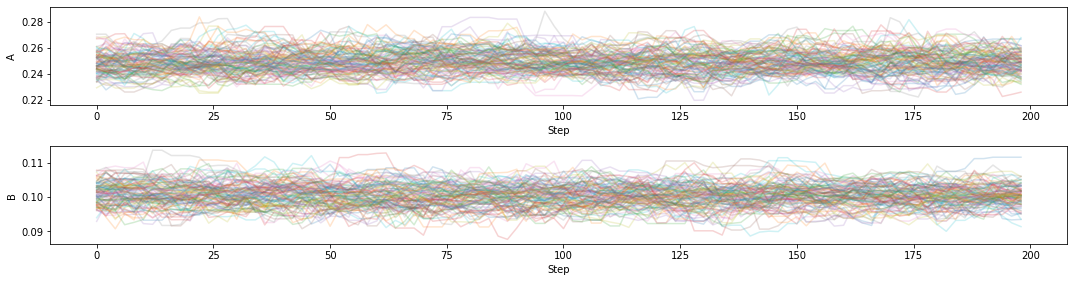

In [14]:
# Walker vs step

Names = AllData["labels"]

with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 100)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        ax.set_ylabel(Names[i])
        ax.set_xlabel('Step')
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('MCMCSamples.pdf', dpi = 192)

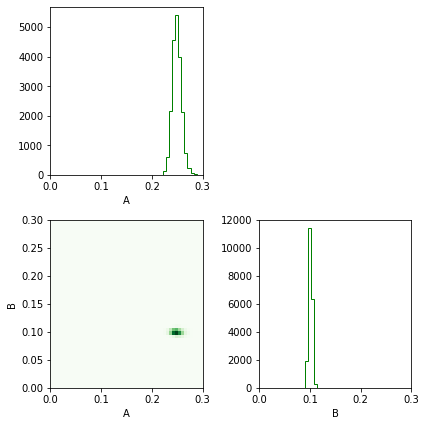

In [15]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('Correlation.pdf', dpi = 192)
# figure

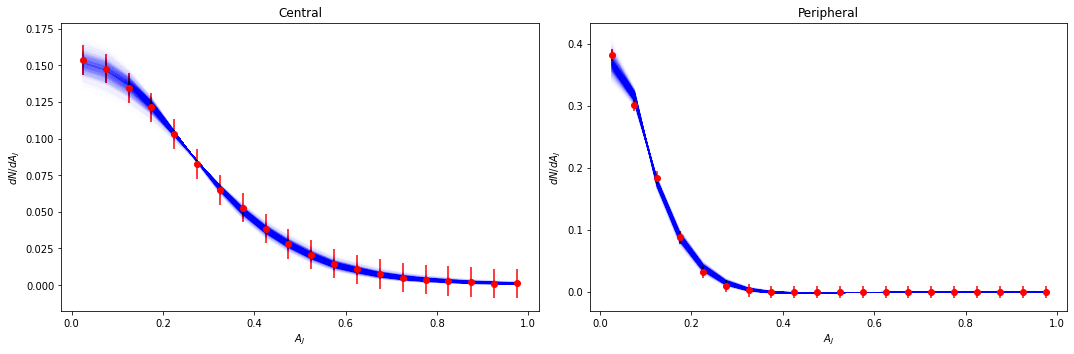

In [16]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2000), :]

TempPrediction = {"PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)

    for i, y in enumerate(TempPrediction[S1][O][S2]):
        axes[s2].plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

axes[0].set_title('Central')
axes[1].set_title('Peripheral')
    
plt.tight_layout(True)
figure.savefig('ObservablePosterior.pdf', dpi = 192)
# figure

In [17]:
# close all plots to save memory
plt.close('all')